In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_preprocessing import timepoint_split, transform_indices, reindex_data, generate_ranks
from pure_svd import build_svd_model, svd_scoring, svd_gridsearch
from knn import uknn_scoring, uknn_gridsearch, build_uknn_model
from evaluation import model_evaluate, topn_recommendations

%config InlineBackend.figure_format = "svg"
plt.rcParams["figure.figsize"] = 10, 6

## Amazon-reviews

In [2]:
# !mkdir -p data/amazon_reviews
# !wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Grocery_and_Gourmet_Food.csv --no-check-certificate
# !mv Grocery_and_Gourmet_Food.csv data/amazon_reviews

In [3]:
reviews = pd.read_csv("data/amazon_reviews/Grocery_and_Gourmet_Food.csv", names=["userid", "itemid", "rating", "timestamp"])

In [4]:
len(reviews)

5074160

In [5]:
reviews.nunique()

userid        283507
itemid       2695974
rating             5
timestamp       5221
dtype: int64

In [6]:
# K-core filtering

k_filter = 20

n_interactions = reviews.groupby("userid").size()
enough = n_interactions[n_interactions > k_filter].index
reviews = reviews[reviews.userid.isin(enough)]

n_interactions = reviews.groupby("itemid").size()
enough = n_interactions[n_interactions > k_filter].index
reviews = reviews[reviews.itemid.isin(enough)]

In [7]:
len(reviews) / 1e6

0.193212

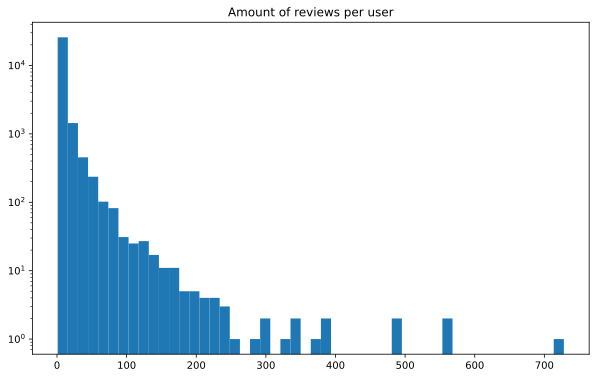

In [8]:
plt.hist(reviews.groupby("userid").size(), bins=50)
plt.yscale("log")
plt.title("Amount of reviews per user")
plt.show()

In [9]:
# Split for final evaluation
_train, _test, _holdout = timepoint_split(reviews, time_split_q=0.95)

len(_train), len(_test), len(_holdout)

(107153, 74000, 4421)

In [10]:
# Additional split for hyperparameter tuning
_trainval, _testval, _holdoutval = timepoint_split(_train, time_split_q=0.95)

len(_trainval), len(_testval), len(_holdoutval)

(76578, 23575, 2965)

In [11]:
def reindex_all(train, test, holdout=None, userid='userid', itemid='itemid'):
    train_new, data_index = transform_indices(train, userid, itemid)
    test_new = reindex_data(test, data_index, fields='items')
    
    if holdout is None:
        return train_new, test_new, data_index
    
    holdout_new = reindex_data(holdout, data_index, fields='items')
    return train_new, test_new, holdout_new, data_index


trainval, testval, holdoutval, data_index_val = reindex_all(_trainval, _testval, _holdoutval)

## Popular

In [12]:
data_description = {
    "n_users": trainval.userid.nunique(),
    "n_items": trainval.itemid.nunique(),
    "feedback": "rating",
    "items": "itemid",
    "users": "userid",
}

In [13]:
topn = 20

In [53]:
alphas = [2 ** p for p in range(12)]

popular_results = []

for a in alphas:
    def damped_mean(ratings):
        return sum(ratings) / (len(ratings) + a)
    
    item2rating = trainval.groupby('itemid')["rating"].apply(damped_mean)
    best_items = item2rating.nlargest(topn).index.values
    popular_recs = np.ones((len(holdoutval), topn)) * best_items
    metric = model_evaluate(popular_recs, holdoutval, data_description, topn)    
    
    popular_results.append({
        "alpha": a, "metric": metric
    })

popular_results = pd.DataFrame(popular_results)

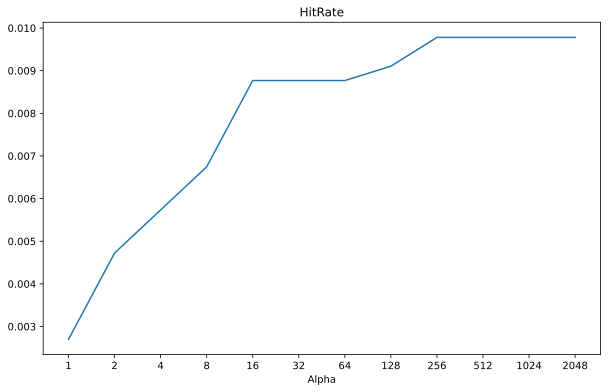

In [15]:
plt.plot(popular_results["alpha"], popular_results["metric"])
plt.xscale("log")
plt.xticks(popular_results["alpha"], popular_results["alpha"])
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Alpha")

plt.show()

In [16]:
popular_results = popular_results.sort_values("metric", ascending=False)

popular_results.head()

,alpha,metric
8,256,0.009781
9,512,0.009781
10,1024,0.009781
11,2048,0.009781
7,128,0.009106


## Pure SVD

In [17]:
data_description = {
    "n_users": trainval.userid.nunique(),
    "n_items": trainval.itemid.nunique(),
    "feedback": "rating",
    "items": "itemid",
    "users": "userid",
}

In [18]:
ranks = [b * 2 ** p for p in range(0, 9) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512, 768]

In [19]:
%%time
svd_results = svd_gridsearch(ranks, trainval, testval, holdoutval, data_description, topn=20)

Interaction matrix shape: (19038, 5548)
Matrix density: 0.0006782151554667767
CPU times: user 1min 5s, sys: 4.64 s, total: 1min 9s
Wall time: 22.1 s


In [20]:
svd_results = pd.DataFrame(svd_results)

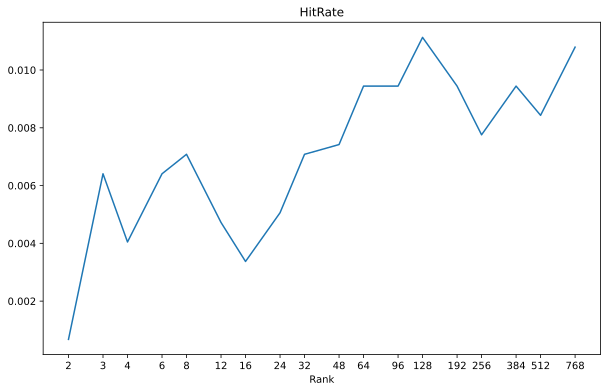

In [21]:
plt.plot(svd_results["rank"], svd_results["metric"])
plt.xscale("log")
plt.xticks(svd_results["rank"], svd_results["rank"])
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Rank")

plt.show()

In [22]:
svd_results = svd_results.sort_values("metric", ascending=False)

svd_results.head()

,rank,metric
12,128,0.011130
17,768,0.010793
10,64,0.009444
15,384,0.009444
13,192,0.009444


## Scaled SVD

In [23]:
from scaled_svd import build_scaled_svd_model, scaled_svd_gridsearch

In [24]:
ranks = [b * 2 ** p for p in range(0, 9) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512, 768]

In [25]:
scalings = np.arange(1, 10, 2) / 10
scalings

array([0.1, 0.3, 0.5, 0.7, 0.9])

In [26]:
%%time
scaled_svd_results = scaled_svd_gridsearch(ranks, scalings, trainval, testval, holdoutval, data_description, topn)

Scaling 0.1
Scaling 0.3
Scaling 0.5
Scaling 0.7
Scaling 0.9
CPU times: user 11min 47s, sys: 27.5 s, total: 12min 14s
Wall time: 3min 58s


In [27]:
scaled_svd_results = pd.DataFrame(scaled_svd_results)

scaled_svd_results = scaled_svd_results.sort_values("metric", ascending=False)

scaled_svd_results.head()

,rank,scaling,metric
48,128,0.5,0.011804
71,768,0.7,0.011804
89,768,0.9,0.011467
53,768,0.5,0.011130
17,768,0.1,0.011130


## SeqSVD

In [47]:
from seq_svd import full_seq_svd_gridsearch, build_seq_svd_model

In [31]:
ranks = [b * 2 ** p for p in range(0, 7) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192]

In [32]:
coefs = [0.25, 0.5, 0.75]
thresholds = [0.003, 0.03] 
powers = [1, 0.75]
sim_types = ["cosine"]
scalings = np.arange(1, 10, 2) / 10
scalings

array([0.1, 0.3, 0.5, 0.7, 0.9])

In [33]:
seq_svd_results = full_seq_svd_gridsearch(ranks, coefs, powers, thresholds, sim_types, scalings,
                                          trainval, testval, holdoutval, data_description, topn)

Sequence similarity coef: 0.25, power: 1, threshold: 0.003, similarity type: cosine, scaling: 0.1
Sequence similarity coef: 0.25, power: 1, threshold: 0.003, similarity type: cosine, scaling: 0.3
Sequence similarity coef: 0.25, power: 1, threshold: 0.003, similarity type: cosine, scaling: 0.5
Sequence similarity coef: 0.25, power: 1, threshold: 0.003, similarity type: cosine, scaling: 0.7
Sequence similarity coef: 0.25, power: 1, threshold: 0.003, similarity type: cosine, scaling: 0.9
Sequence similarity coef: 0.25, power: 1, threshold: 0.03, similarity type: cosine, scaling: 0.1
Sequence similarity coef: 0.25, power: 1, threshold: 0.03, similarity type: cosine, scaling: 0.3
Sequence similarity coef: 0.25, power: 1, threshold: 0.03, similarity type: cosine, scaling: 0.5
Sequence similarity coef: 0.25, power: 1, threshold: 0.03, similarity type: cosine, scaling: 0.7
Sequence similarity coef: 0.25, power: 1, threshold: 0.03, similarity type: cosine, scaling: 0.9
Sequence similarity coef:

In [34]:
seq_svd_results = pd.DataFrame(seq_svd_results)

seq_svd_results = seq_svd_results.sort_values("metric", ascending=False)

In [35]:
seq_svd_results.head()

,rank,incomplete_cholesky_threshold,sequence_similarity_coef,similarity_type,power,scaling,metric
482,16,0.003,0.50,cosine,0.75,0.9,0.015177
766,64,0.003,0.75,cosine,0.75,0.9,0.014503
719,12,0.003,0.75,cosine,0.75,0.3,0.014165
762,16,0.003,0.75,cosine,0.75,0.9,0.014165
468,16,0.003,0.50,cosine,0.75,0.7,0.013828


In [ ]:
seq_svd_results.to_csv("seq_svd_tuning_amazon_grocery.csv")

## UserKNN

In [23]:
data_description = {
    "n_users": trainval.userid.nunique(),
    "n_items": trainval.itemid.nunique(),
    "feedback": "rating",
    "weights": "weights",
    "items": "itemid",
    "users": "userid",
}

trainval, testval = generate_ranks(trainval, data_description), generate_ranks(testval, data_description)

In [81]:
k_vals = [10, 25, 50, 100, 200, 250, 500, 1000, None]
p_vals = [0] # np.linspace(0, 1, 21)

config = {
    "similarity_A": "cosine", 
    "similarity_T": None,
}

In [82]:
%%time
results = uknn_gridsearch(k_vals, p_vals, config, trainval, testval, holdoutval, data_description, topn)

CPU times: total: 1.69 s
Wall time: 1.69 s


In [83]:
knn_results = pd.DataFrame(results)

In [84]:
knn_results.drop("power", axis=1).sort_values('metric', ascending=False).head()

,k,metric
3,100.0,0.018212
4,200.0,0.017875
5,250.0,0.017875
1,25.0,0.017538
2,50.0,0.017201


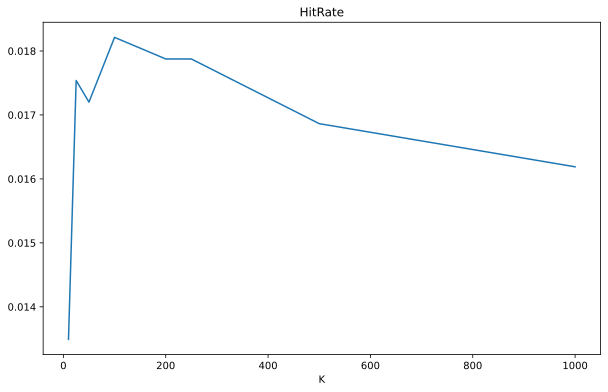

In [85]:
plt.plot(k_vals, knn_results.sort_values("k", na_position="last")["metric"])

plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("K")

plt.show()

## SeqUserKNN

In [86]:
%%time
k_vals = [10, 25, 50, 100, 200, 250, 500, 1000, None]
p_vals = np.linspace(0, 1, 21)

config = {
    "similarity_A": "cosine", 
    "similarity_T": "cosine",
}

results = uknn_gridsearch(k_vals, p_vals, config, trainval, testval, holdoutval, data_description, topn)

CPU times: total: 30.6 s
Wall time: 31.1 s


In [91]:
seq_knn_results = pd.DataFrame(results)
seq_knn_results.sort_values('metric', ascending=False).head()

,power,k,metric
61,0.3,1000.0,0.021248
60,0.3,500.0,0.021248
59,0.3,250.0,0.021248
58,0.3,200.0,0.021248
62,0.3,NaN,0.021248


In [92]:
seq_knn_results.pivot(index="power", columns="k", values="metric").style.format("{:.5f}").background_gradient(high=0.3, axis = None)


k,nan,10.000000,25.000000,50.000000,100.000000,200.000000,250.000000,500.000000,1000.000000
power,,,,,,,,,
0.000000,0.019899,0.01315,0.01855,0.01889,0.02024,0.02057,0.02024,0.01990,0.01990
0.050000,0.019562,0.01282,0.01821,0.01821,0.01990,0.02024,0.01990,0.01956,0.01956
0.100000,0.020236,0.01315,0.01889,0.01922,0.02024,0.02024,0.02024,0.02024,0.02024
0.150000,0.020236,0.01349,0.01855,0.01821,0.02024,0.01990,0.02024,0.02024,0.02024
0.200000,0.020573,0.01349,0.01889,0.01922,0.01990,0.02057,0.02057,0.02057,0.02057
0.250000,0.020573,0.01349,0.01855,0.01922,0.02024,0.02057,0.02057,0.02057,0.02057
0.300000,0.021248,0.01383,0.01922,0.01956,0.02091,0.02125,0.02125,0.02125,0.02125
0.350000,0.020236,0.01383,0.01720,0.01821,0.01990,0.02024,0.02024,0.02024,0.02024
0.400000,0.019562,0.01349,0.01754,0.01855,0.01990,0.01990,0.01990,0.01956,0.01956


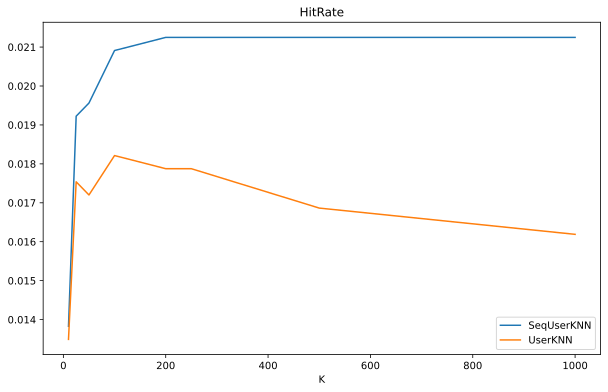

In [104]:
plt.plot(k_vals, seq_knn_results[lambda x: np.isclose(x["power"], 0.3)]["metric"], label="SeqUserKNN")
plt.plot(k_vals, knn_results["metric"], label="UserKNN")
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("K")
plt.legend()

plt.show()

In [37]:
knn_results.sort_values('metric', ascending=False).head()

,alpha,k,metric
44,1.0,NaN,0.012816
43,1.0,1000.0,0.012816
42,1.0,500.0,0.012816
36,1.0,10.0,0.012479
33,0.8,500.0,0.012479


## Final Eval

In [436]:
train, test, holdout, data_index = reindex_all(_train, _test, _holdout)

In [437]:
data_description = {
    "n_users": train.userid.nunique(),
    "n_items": train.itemid.nunique(),
    "feedback": "rating",
    "weights": "weights",
    "items": "itemid",
    "users": "userid",
}

In [438]:
train, test = generate_ranks(train, data_description), generate_ranks(test, data_description)

In [40]:
grand_total = []

In [41]:
def damped_mean(ratings):
    return sum(ratings) / (len(ratings) + popular_results["alpha"].iloc[0])

item2rating = train.groupby('itemid')["rating"].apply(damped_mean)
best_items = item2rating.nlargest(topn).index.values
popular_recs = np.ones((len(holdout), topn)) * best_items
metric = model_evaluate(popular_recs, holdout, data_description, topn)    

grand_total.append(
    {"method": "popularity", "metric": metric}
)

In [42]:
best_rank = svd_results["rank"].iloc[0]
print("Best rank:", best_rank)

model = build_svd_model({"rank": best_rank}, train, data_description)
scores = svd_scoring(model, test, data_description)
svd_recs = topn_recommendations(scores, topn)

metric = model_evaluate(svd_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "PureSVD", "metric": metric}
)

Best rank: 128
Interaction matrix shape: (22920, 5604)
Matrix density: 0.000777585942726026


In [43]:
best_config = {
    "rank": scaled_svd_results["rank"].iloc[0],
    "scaling": scaled_svd_results["scaling"].iloc[0],
}
print(best_config)

model = build_scaled_svd_model(best_config, train, data_description)
scores = svd_scoring(model, test, data_description)
svd_recs = topn_recommendations(scores, topn)

metric = model_evaluate(svd_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "ScaledSVD", "metric": metric}
)

{'rank': 128, 'scaling': 0.5}


In [45]:
seq_svd_results = pd.DataFrame([{
    "rank": 16,
    "incomplete_cholesky_threshold": 0.003,
    "sequence_similarity_coef": 0.5,
    "similarity_type": "cosine",
    "power": 0.75,
    "scaling": 0.9,
}])

seq_svd_results

,rank,incomplete_cholesky_threshold,sequence_similarity_coef,similarity_type,power,scaling
0,16,0.003,0.5,cosine,0.75,0.9


In [48]:
best_config = {
    "rank": seq_svd_results["rank"].iloc[0], 
    "sequence_similarity_coef": seq_svd_results["sequence_similarity_coef"].iloc[0],
    "similarity_type": seq_svd_results["similarity_type"].iloc[0],
    "incomplete_cholesky_threshold": seq_svd_results["incomplete_cholesky_threshold"].iloc[0],
    "scaling": seq_svd_results["scaling"].iloc[0],
    "power": seq_svd_results["power"].iloc[0],
}
print(best_config)

model = build_seq_svd_model(best_config, train, data_description)
scores = svd_scoring(model, test, data_description)
svd_recs = topn_recommendations(scores, topn)

metric = model_evaluate(svd_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "SeqSVD", "metric": metric}
)

{'rank': 16, 'sequence_similarity_coef': 0.5, 'similarity_type': 'cosine', 'incomplete_cholesky_threshold': 0.003, 'scaling': 0.9, 'power': 0.75}


In [34]:
best_config = {
    "weights": False,
    "k": 100,
    "similarity": "cosine"
}
print(best_config)

model = build_uknn_model(best_config, train, data_description)
scores = uknn_scoring(model, test, data_description)
uknn_recs = topn_recommendations(scores, topn)

metric = model_evaluate(uknn_recs, holdout, data_description, topn)
metric

{'weights': False, 'k': 100, 'similarity': 'cosine'}


0.019904998869034154

In [444]:
best_config = {
    "similarity_T": "cosine",
    "similarity_A": "cosine",
    "k": 200,
    "power": 0.3
}
print(best_config)

model = build_uknn_model(best_config, train, data_description)
scores = uknn_scoring(model, test, data_description)
uknn_recs = topn_recommendations(scores, topn)

metric = model_evaluate(uknn_recs, holdout, data_description, topn)
metric

{'similarity_T': 'cosine', 'similarity_A': 'cosine', 'k': 200, 'power': 0.3}


0.022619316896629722

In [49]:
pd.DataFrame(grand_total).sort_values("metric", ascending=False)

,method,metric
3,SeqSVD,0.009952
2,ScaledSVD,0.008143
1,PureSVD,0.007464
0,popularity,0.003845
